In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import astropy.units as u
import astropy.coordinates as coord

import gala.coordinates as gc
import gala.potential as gp
import gala.dynamics as gd
from gala.dynamics import mockstream as ms
from gala.dynamics.nbody import DirectNBody
from gala.units import galactic, UnitSystem

import pandas as pd

import h5py

#Reading GD1 data
df_desi = pd.read_csv('/Users/bsegovia/Downloads/brigette_code/GD-1/GD-1/All_table_at_fig4b_cleaned_copy.csv')


## Redefining the Phase space of the prog and perturber

In [3]:
# CALCULATION for a more realistic radius of the perturber/subhalo 
# Defining constants 
c_o = 19.9 
a = [-0.195, 0.089, 0.089]
b = -0.54
x_sub = 1
rho_c = 8.5 * 10**(-27) * (u.kg/u.m**3) #kg/m^3
h = 0.7 #normalized hubble parameter 

m_200 = 1e7 * u.Msun # using only one value for now 

#Calculating r_200 
r_200 = (m_200 * (3/(4*np.pi))*(1/rho_c))**(1/3)

#Calculating c_200 
term = 0 
for i in range(len(a)):
    term +=   (a[i]*np.log(m_200 / (1e8 * h * u.Msun) ) )**i
c_200 = c_o * (1 + term) * (1 + b*np.log(x_sub))

#calculating radius of the perturber
r_s = r_200/c_200

c = r_s.to(u.pc)



In [4]:
# Define parameters for the Plummer potential (progenitor)

perturber_mass = 5e7 * u.Msun

#calculating radius of the perturber
r_s = r_200/c_200
r = r_s.to(u.pc)  # Make sure it's in units compatible with your potential's normalization

# Initialize the Plummer potential for the progenitor
pert_pot_for_vesc = gp.HernquistPotential(m=perturber_mass, c=r_s.to(u.kpc) , units=galactic) #DM

# Convert position to galactic units (normalize by galactic scale)
r_dimensionless = (r / galactic['length']).decompose()

# Calculate the potential energy at radius r (3D position in dimensionless units)
potential_at_r = pert_pot_for_vesc.energy([r_dimensionless, 0, 0])

# Calculate escape velocity using v_esc = sqrt(-2 * Phi(r))
v_esc = np.sqrt(-2 * potential_at_r)

# Output escape velocity (in km/s)
print(f"Escape velocity at r = {r}: {v_esc.to(u.km/u.s)}")

Escape velocity at r = 722.26346645077 pc: [17.25510962] km / s


In [5]:
r_s.to(u.kpc).value

v_esc = v_esc.to(u.km/u.s)  # Ensure v_esc is in km/s
d_vel = v_esc[0].value/2
d_vel

8.627554808798456

## Integration of the Stream

In [6]:
pot = gp.CCompositePotential()
pot['hernquist'] = gp.HernquistPotential(m=0.6E10*u.Msun, c=0.7*u.kpc, units=galactic)
pot['MNdisk'] = gp.MiyamotoNagaiPotential(m=5E10*u.Msun, a=3*u.kpc, b=0.26*u.kpc, units=galactic)
pot['LSNFW'] = gp.LeeSutoTriaxialNFWPotential(v_c=220.*u.km/u.s, r_s=20.*u.kpc, a=1, b=1., c=0.87, units=galactic)

static_frame = gp.StaticFrame(galactic) #new addition
H = gp.Hamiltonian(potential=pot, frame=static_frame)


# Gaia coordinates of GD1 core IC in Standard Galactic Cartesian coordinates (from Koposov et al 2010):
prog_w0_before = gd.PhaseSpacePosition(pos=[-3.41,13.00,9.58]*u.kpc,
                           vel=[-200.4,-162.6,13.9]*u.km/u.s)
prog_mass = 1e5 * u.Msun #monicas is 1e4 mine is 1e5


# # #Define DM subhalo information
# perturber_w0_before = gd.PhaseSpacePosition(pos=[-4.41-r_s.to(u.kpc).value,13.00,9.58]*u.kpc,
#                            vel=[-200.4-d_vel,-162.6,13.9]*u.km/u.s) #-195.4 ; now using 1/2 of the calculated v_esc
perturber_mass = 5e6 * u.Msun

# #Define the combined initial conditions
# w0_combined = gd.combine((prog_w0_before, perturber_w0_before))

In [7]:
#Potentials 
prog_pot = gp.PlummerPotential(m=prog_mass, b=4*u.pc, units=galactic) 
perturber_pot = gp.HernquistPotential(m=perturber_mass, c=r_s.to(u.kpc) , units=galactic) 

# tot_pot = [prog_pot, perturber_pot]

In [8]:
# perturber_before = gd.DirectNBody(perturber_w0_before, [perturber_pot], external_potential=pot)

In [9]:
df = ms.ChenStreamDF()
gen = ms.MockStreamGenerator(df, H, progenitor_potential=prog_pot) #there's no more arguments here

#nbody=nbody of DM because this is how many other objects can affect the stream

#Foward integration of the stream
stream, prog = gen.run(prog_w0=prog_w0_before, prog_mass=prog_mass, nbody=None, #perturber_before, 
                                 release_every=1, n_particles=1, 
                                 #output_every=False, output_filename='snapshot_files/snapshots', check_filesize=True, overwrite=True, 
                                 progress=False, dt=2*u.Myr, n_steps=2500)





In [10]:
prog_w0 = gd.PhaseSpacePosition(pos = [prog[0].pos.x.value , 
                                       prog[0].pos.y.value , 
                                       prog[0].pos.z.value ]*u.kpc, 
                                       vel = [prog[0].vel.d_x.to(u.km/u.s).value, prog[0].vel.d_y.to(u.km/u.s).value, prog[0].vel.d_z.to(u.km/u.s).value]*-u.km/u.s)


perturber_w0 = gd.PhaseSpacePosition(pos = [prog[0].pos.x.value + 1 ,
                                            prog[0].pos.y.value , 
                                            prog[0].pos.z.value]*u.kpc , 
                                            vel = [prog[0].vel.d_x.to(u.km/u.s).value - d_vel, prog[0].vel.d_y.to(u.km/u.s).value, prog[0].vel.d_z.to(u.km/u.s).value]*-u.km/u.s)

perturber = gd.DirectNBody(perturber_w0, [perturber_pot], external_potential=pot)

#Using these new initial conditions, we can now generate the stream backwards in time to end in a guessed location that is close to the progenitor's current location.
w0_combined = gd.combine((prog_w0, perturber_w0)) #this is not actually used, but saved
perturber = gd.DirectNBody(perturber_w0, [perturber_pot], external_potential=pot) #same thing as before but new initial conditions
 


df = ms.ChenStreamDF()
gen = ms.MockStreamGenerator(df, H, progenitor_potential=prog_pot) #there's no more arguments here




In [11]:
#Back integration of the stream
stream_new, prog_new = gen.run(prog_w0=prog_w0, prog_mass=prog_mass, nbody=perturber, 
                                 release_every=1, n_particles=1, 
                                 #output_every=False, output_filename='snapshot_files/snapshots', check_filesize=True, overwrite=True, 
                                 progress=False, dt=2*u.Myr, n_steps=2500)

## Comparing to DESI data

In [12]:
stream_icrs = stream_new.to_coord_frame(coord.ICRS())
prog_icrs = prog_new.to_coord_frame(coord.ICRS())
stream_gc = stream_new.to_coord_frame(coord.Galactic())
prog_gc = prog_new.to_coord_frame(coord.Galactic())

In [13]:
phi1 = df_desi['phi_1'] * u.rad
phi2 = df_desi['phi_2'] * u.rad

gd1_sim = stream_icrs.transform_to(gc.GD1Koposov10())

In [14]:
x_range = (gd1_sim.phi1 >= -90 * u.deg) & (gd1_sim.phi1 <= 5 * u.deg)

/var/folders/6w/4l8xsqjn63b50789db29p6tm0000gr/T/ipykernel_5878/2480989976.py:24: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc1=ax.scatter(phi1, phi2, color='red', marker='.', s=50, cmap='tab20b',label='Observed')


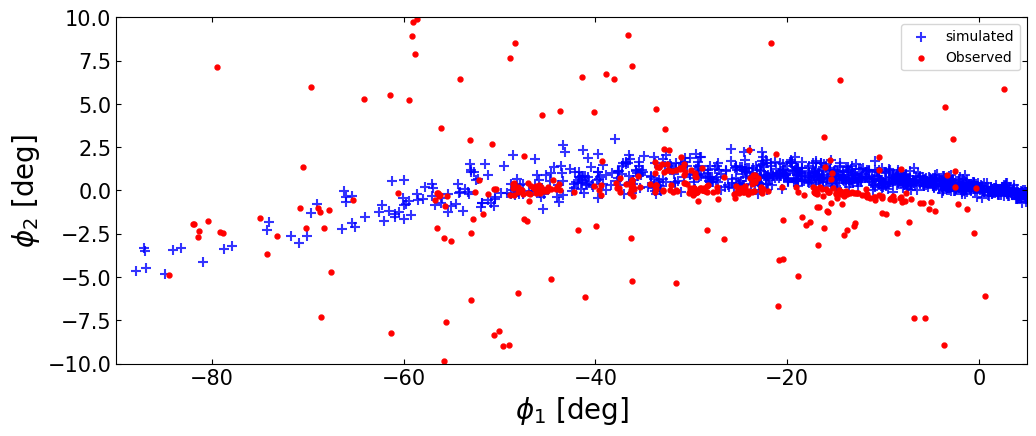

In [15]:
#sample  scatter plot:
# ------- Figure object
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(11)
    
# ------- Axis object
ax = plt.subplot(1,1,1)
ax.tick_params(axis='both',which='both',direction='in',
                   labelsize=15,right=True,top=True)
#ax.xaxis.set_ticks(np.arange(-400,400, step=100.))
#ax.yaxis.set_ticks(np.arange(-400,400, step=100.))
ax.set_xlabel(r'$\phi_1$ [deg]',fontsize=20)
ax.set_ylabel(r'$\phi_2$ [deg]',fontsize=20)

#ax.set_xlim(-420.,420.)

ax.set_ylim(-10.,10.)
ax.set_xlim(-90, 5.)
ax.scatter(gd1_sim.phi1[x_range], gd1_sim.phi2[x_range], marker='+', s=50,color='blue', alpha = 0.8, label='simulated')
#c=gd1sim_dvel.to_value(u.km / u.s)

# ------- Plot
sc1=ax.scatter(phi1, phi2, color='red', marker='.', s=50, cmap='tab20b',label='Observed') 
#               vmin=-150., vmax=150.,edgecolor='none',alpha=0.8)

ax.legend()
ax.grid(False)



ax.grid(False)
fig.tight_layout(pad=3.0)
plt.savefig('phi1_phi2_plots/GD1_sim_dat_with_perturber_comp_pot.png')
plt.show()
plt.close()

### Creating Histogram

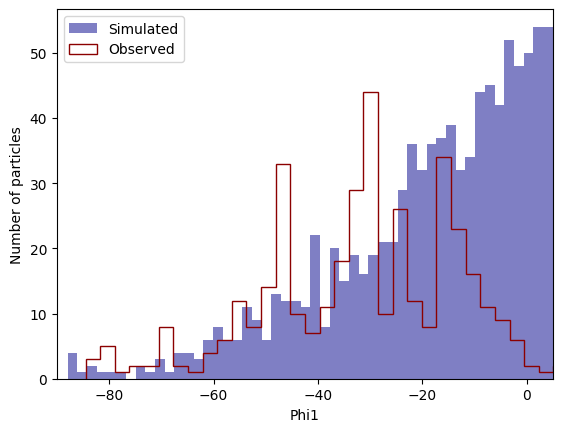

In [16]:
# ------- Figure object
fig = plt.figure()

# Histogram data for the simulated and observed values
sim_counts, sim_bins, _ = plt.hist(gd1_sim.phi1[x_range], bins=50, color='darkblue', alpha=0.5, label='Simulated')
obs_counts, obs_bins, _ = plt.hist(phi1, bins=50, histtype='step', color='darkred', label='Observed')

# # Get bin centers for plotting the line
# sim_bin_centers = 0.5 * (sim_bins[:-1] + sim_bins[1:])
# obs_bin_centers = 0.5 * (obs_bins[:-1] + obs_bins[1:])

# # Plotting the total number of particles for a given phi1 using a line plot
# plt.plot(sim_bin_centers, sim_counts, color='darkblue', label='Simulated (Line)')
# plt.plot(obs_bin_centers, obs_counts, color='lightgrey', label='Observed (Line)')

# Labels and legend
plt.xlabel('Phi1')
plt.ylabel('Number of particles')
plt.xlim(-90, 5)
plt.legend()

# Show the plot
plt.show()
